In [48]:
import os

import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import sgpp, sgml, sgutil
import joblib

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [139]:
from itertools import combinations, product
rec = ['pressure', 'humidity', 'windspeed']
feat = ['pressure', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
rec_cols = [i + '_rec' for i in rec]
prod2_1 = [(a, b) for a, b in combinations(feat, 2)]
prod2_2 = [(a, b + '_rec') for a, b in product(feat, rec) if (a != b)]
prod2_3= [(a, a) for a in feat]
prod2_4= [(a + '_rec', a + '_rec') for a in rec]
prod3_1 = [(a, b, c) for a, b, c in combinations(feat, 3)]
prod3_2 = [(a, b, c + '_rec') for a, b, c in product(feat, feat, rec) if (a != c) and (b != c) and (a >= b)]
prod3_3 = [(a, b + '_rec', c + '_rec') for a, b, c in product(feat, rec, rec) if (a != b) and (a != c) and (b >= c)]
prod2 = prod2_1 + prod2_2 + prod2_3 + prod2_4
prod3 = prod3_1 + prod3_2 + prod3_3
prod2_name = ['_'.join(i) for i in prod2]
prod3_name = ['_'.join(i) for i in prod3]

In [140]:
rec = ['pressure', 'humidity', 'windspeed']
rec_cols = [i + '_rec' for i in rec]

expr_rec_dic = {i + '_rec': 1 / pl.col(i) for i in rec}
expr2_dic = {'_'.join(i) : pl.col(i[0]) * pl.col(i[1]) for i in prod2}
expr3_dic = {'_'.join(i) : pl.col(i[0]) * pl.col(i[1]) * pl.col(i[2]) for i in prod3}

p1 = make_pipeline(
    sgpp.PolarsProcessor(predefined_types = {'id': pl.Int64}),
    sgpp.ExprProcessor({
        'winddirection': pl.col('winddirection').fill_null(strategy = 'forward'),
        'windspeed': pl.col('windspeed').fill_null(strategy = 'forward')
    }),
    sgpp.ExprProcessor({
        'cos_wd': (pl.col('winddirection') / 180 * np.pi).cos() * pl.col('windspeed'),
        'sin_wd': (pl.col('winddirection') / 180 * np.pi).sin() * pl.col('windspeed'),
        'expected_day': (pl.col('id') % 365) + 1,
        'sin_ed': ((pl.col('id') % 365) / 365 * np.pi).sin(),
        'year': pl.col('id') // 365, 
    })
)
df_train = p1.fit_transform(['data/train_lb.csv'])
df_test = p1.transform(['data/test.csv'])
p2 = make_pipeline(
    sgpp.ExprProcessor(expr_rec_dic),
    sgpp.ExprProcessor(expr2_dic),
    sgpp.ExprProcessor(expr3_dic),
    sgpp.PandasCoverter(index_col = 'id')
)
df_all = p2.fit_transform(
    pl.concat([df_train, df_test[146:]], how = 'align')
)

p3 = make_pipeline(
    sgpp.ApplyWrapper(
        StandardScaler().set_output(transform='pandas'), 
        ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed'] + ['cos_wd', 'sin_wd'] + prod2_name + prod3_name + rec_cols
    ),
    sgpp.ApplyWrapper(
        MinMaxScaler().set_output(transform='pandas'), ['year', 'expected_day', 'winddirection']
    )
)
df_all = p3.fit_transform(df_all)
df_train = df_all.loc[df_all['rainfall'].notna()]

target = 'rainfall'
sc = sgutil.SGCache('img', 'result', 'model')

In [141]:
df_org = make_pipeline(
    sgpp.PolarsProcessor(predefined_types = {'id': pl.Int64, 'day': pl.Int16, 'rainfall': pl.String}),
    sgpp.ColumnNameCleaner(),
    sgpp.ExprProcessor({
        'winddirection': pl.col('winddirection').fill_null(strategy = 'forward'),
        'windspeed': pl.col('windspeed').fill_null(strategy = 'forward')
    }),
    sgpp.ExprProcessor({
        'id': -pl.arange(pl.col('day').len(), 0, -1),
        'expected_day': pl.arange(1, pl.col('day').len() + 1),
        'sin_ed': (pl.arange(1, pl.col('day').len() + 1) / 365 * np.pi).sin(),
        'cos_wd': (pl.col('winddirection') / 180 * np.pi).cos() * pl.col('windspeed'),
        'sin_wd': (pl.col('winddirection') / 180 * np.pi).sin() * pl.col('windspeed'),
        'chp': pl.col('cloud') * pl.col('humidity') / pl.col('pressure'),
        'rainfall': pl.col('rainfall').replace({'yes': 1, 'no': 0}).cast(pl.Int8),
        'year': -1
    }),
    *p2
).fit_transform(['data/Rainfall.csv'])
df_org = p3.transform(df_org)

In [142]:
df_all[prod2_name]

,pressure_temparature,pressure_dewpoint,pressure_humidity,pressure_cloud,pressure_sunshine,pressure_windspeed,temparature_dewpoint,temparature_humidity,temparature_cloud,temparature_sunshine,...,pressure_pressure,temparature_temparature,dewpoint_dewpoint,humidity_humidity,cloud_cloud,sunshine_sunshine,windspeed_windspeed,pressure_rec_pressure_rec,humidity_rec_humidity_rec,windspeed_rec_windspeed_rec
id,,,,,,,,,,,,,,,,,,,,,
0,-0.633374,-0.183019,0.659466,0.688897,-0.722016,-0.474663,-0.548159,-0.392019,0.035702,-0.744303,...,0.678544,-0.747859,-0.366902,0.599829,0.713756,-0.699082,-0.541632,-0.686623,-0.560021,-0.129671
1,-1.349395,-0.943306,1.715427,0.866098,-1.026873,0.003963,-1.204758,-0.808978,-0.500466,-0.971293,...,1.053914,-1.334394,-1.093313,1.761122,0.944372,-0.731834,-0.192780,-1.056016,-1.138602,-0.403999
2,-1.491785,-2.106387,-0.822947,-1.572964,1.288559,-0.371862,-1.725448,-1.697837,-2.024126,0.367304,...,1.878862,-1.445994,-1.879580,-0.950689,-1.663259,1.132857,-0.481323,-1.857237,0.679415,-0.199100
3,-1.194057,-0.693819,1.642043,1.057243,-1.026873,1.367143,-1.022071,-0.618031,-0.201859,-0.971293,...,-0.034312,-1.202376,-0.858065,1.761122,1.263884,-0.731834,1.302611,0.023338,-1.138602,-0.678499
4,-1.047622,-2.052688,-3.820863,-1.690525,-0.024845,0.302732,-1.598679,-2.257728,-1.885062,-0.307754,...,1.465922,-1.110560,-1.849991,-3.280454,-1.742278,-0.381037,0.064308,-1.457984,5.892457,-0.501244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,-1.207966,-1.266334,1.860334,1.095653,-1.026873,1.261697,-1.294923,-0.621157,-0.238916,-0.971293,...,1.286675,-1.232305,-1.351471,1.913462,1.263884,-0.731834,1.130112,-1.283543,-1.200937,-0.665590
2916,-1.141587,-0.851614,-0.556370,0.219287,-0.585929,0.318020,-1.066541,-1.241571,-0.675808,-0.681195,...,-0.336428,-1.156848,-0.994997,-0.584594,0.136573,-0.662541,0.102274,0.327645,0.315341,-0.512090
2917,-1.024804,-0.914766,1.365399,1.161391,-1.026873,0.010911,-1.079967,-0.593464,-0.036074,-0.971293,...,1.627403,-1.094961,-1.077188,1.313673,1.345909,-0.731834,-0.192780,-1.614531,-0.939247,-0.403999


In [143]:
from scipy.stats import mannwhitneyu

In [144]:
s_mann = df_train[rec_cols + prod2_name + prod3_name].apply(
    lambda x: mannwhitneyu(
        x.loc[df_train[target] == 0],
        x.loc[df_train[target] == 1]
    ).pvalue
)

<Axes: ylabel='Count'>

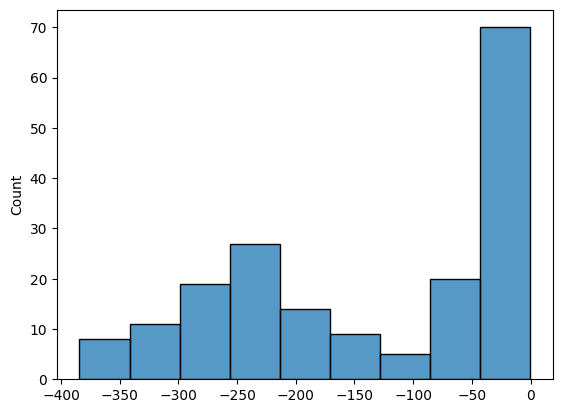

In [145]:
sns.histplot(np.log(s_mann.sort_values()))

In [151]:
filter_cols = s_mann.sort_values().index.tolist()

In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from mlxtend.feature_selection import SequentialFeatureSelector

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

def include_org(df, include_org = False):
    return pd.concat([df, df_org]) if include_org else df

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index),
    'score_func': lambda df, prds: roc_auc_score(df[target], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'train_data_proc': include_org,
    'y': target,
}

lr_adapter = sgml.SklearnAdapter(LogisticRegression)
skf = StratifiedKFold(5, random_state = 123, shuffle = True)
ss = StratifiedShuffleSplit(1, random_state = 123)

In [188]:
sfs = SequentialFeatureSelector(
    LogisticRegression(), 'best', forward = True, floating = True, cv =skf, scoring = 'roc_auc'
)
sfs.fit(
    df_train[feat + ['cos_wd', 'sin_wd', 'sin_ed', 'year'] + filter_cols[:50]], df_train[target]
)
sfs.k_feature_names_

/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

('dewpoint',
 'humidity',
 'cloud',
 'windspeed',
 'sin_ed',
 'humidity_cloud_pressure_rec',
 'humidity_cloud',
 'cloud_pressure_rec_pressure_rec',
 'cloud_pressure_rec',
 'sunshine_pressure_rec_humidity_rec',
 'pressure_humidity',
 'humidity_pressure_rec',
 'pressure_dewpoint_cloud',
 'dewpoint_cloud',
 'humidity_pressure_rec_pressure_rec',
 'cloud_pressure_rec_humidity_rec')

In [189]:
hparams = {
    'model_params': {}, 'X_num': list(sfs.k_feature_names_)
}
result = sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

0.8932960382177942

In [191]:
df_coef = pd.concat([i['coef'] for i in result['model_result']], axis=1).agg(['mean', 'std'], axis = 1).assign(
    CV = lambda x: x['std'] / x['mean'].abs()
).sort_values('CV', ascending = False)
df_coef

,mean,std,CV
cloud_pressure_rec,0.005255,0.038901,7.402986
dewpoint_cloud,-0.014324,0.058425,4.078853
humidity,-0.082505,0.069664,0.844369
cloud,-0.090325,0.052830,0.584893
pressure_dewpoint_cloud,-0.143378,0.064496,0.449833
pressure_humidity,-0.319483,0.138544,0.433651
cloud_pressure_rec_pressure_rec,0.102603,0.038039,0.370740
cloud_pressure_rec_humidity_rec,0.396169,0.145486,0.367233
humidity_cloud,0.456923,0.137456,0.300830
humidity_cloud_pressure_rec,0.559460,0.138844,0.248175


In [185]:
sfs = SequentialFeatureSelector(
    LogisticRegression(), 'best', forward = False, floating = True, cv =skf, scoring = 'roc_auc'
)
sfs.fit(
    df_train[feat + ['cos_wd', 'sin_wd', 'sin_ed', 'year'] + filter_cols[:50]], df_train[target]
)
sfs.k_feature_names_

/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

('pressure',
 'dewpoint',
 'cloud',
 'windspeed',
 'sin_ed',
 'humidity_cloud_pressure_rec',
 'sunshine_pressure_humidity_rec',
 'sunshine_sunshine_pressure_rec')

In [186]:
hparams = {
    'model_params': {}, 'X_num': list(sfs.k_feature_names_)
}
result = sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

0.8933401333493627

In [187]:
df_coef = pd.concat([i['coef'] for i in result['model_result']], axis=1).agg(['mean', 'std'], axis = 1).assign(
    CV = lambda x: x['std'] / x['mean'].abs()
).sort_values('CV', ascending = False)
df_coef.iloc[:10]

,mean,std,CV
sunshine_sunshine_pressure_rec,-0.093425,0.043787,0.468692
pressure,-0.118473,0.044143,0.372596
windspeed,0.122181,0.029280,0.239646
cloud,0.485685,0.093598,0.192713
sunshine_pressure_humidity_rec,-0.462191,0.085060,0.184037
sin_ed,-0.463349,0.053104,0.114609
humidity_cloud_pressure_rec,0.858820,0.067807,0.078954
dewpoint,0.522265,0.017195,0.032924


**humidity_cloud_pressure_rec**, **sunshine_humidity_rec_pressure_rec** 사용해볼만한 속성입니다